## Imports

In [1]:
import os
import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D, TimeDistributed, MaxPooling1D, Flatten
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay

from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from parse_data import load_intra_train, load_intra_test, load_cross_train, load_cross_test

## Constants

In [2]:
DOWNSAMPLING_STEP = 8
NUM_CLASSES = 4
BATCH_SIZE = 3

ENCODE_MAP = {
        'rest': 0,
        'motor': 1,
        'memory': 2,
        'math': 3,
    }

INTRA_OR_CROSS_MODE = "cross"

if INTRA_OR_CROSS_MODE == "cross":
    load_train = load_cross_train
    load_test = load_cross_test
elif INTRA_OR_CROSS_MODE == "intra":
    load_train = load_intra_train
    load_test = load_intra_test


## Load data

In [3]:
filenamepath = ("C:/Users/Collin/Documents/Universiteit Utrecht/Periode 4/Deep learning/Project assignment/Final Project data/Final Project data/Intra/train/")

X_train, y_train = load_train(batch_size=BATCH_SIZE,downsample_step=DOWNSAMPLING_STEP,logs=True)

X.shape from Data\Cross\train: (94976, 3, 248)


## LSTM Model only

In [4]:
time_steps = X_train.shape[1]
num_channels = X_train.shape[2]

if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

early_stop = EarlyStopping(
    monitor='val_loss',#'val_accuracy',#
    patience=3,
    restore_best_weights=True
)

lstm_model = Sequential([
    TimeDistributed(Dense(16, kernel_regularizer=l2(1e-4)), input_shape=(time_steps, num_channels)),

    LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(16, kernel_regularizer=l2(1e-3)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])
# optimal: (0.7484416961669922, [7, 100000, 1e-05, 0.95]), 
# or: (0.7486803531646729, [7, 1000000, 0.0001, 0.85])
# or: (0.7519373297691345, [15, 100000, 1e-05, 0.9])]
# [13, 100000, 0.0001, 0.95]
# [13, 100000, 5e-05, 0.94]

lstm_model.compile(optimizer=Nadam(ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20,
    decay_rate=0.9)),#0.94
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
# paramteers to optimise:
# nr of dense layers
# kernel regularizer
# dropout
# learning rate => was 1e-6, nu variabel.


c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
history = lstm_model.fit(
    X_train, y_train,   
    epochs=5,
    batch_size=64,#beste tot nu toe: 64,
    validation_split=0.5,
    callbacks=[early_stop],
    verbose=1
)

# parameters to optimise:
# epochs
# batch size


Epoch 1/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9243 - loss: 0.2131 - val_accuracy: 0.9999 - val_loss: 0.0264
Epoch 2/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9918 - loss: 0.0482 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 3/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9923 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 4/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9927 - loss: 0.0444 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 5/5
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9921 - loss: 0.0452 - val_accuracy: 1.0000 - val_loss: 0.0231


# Training Progress

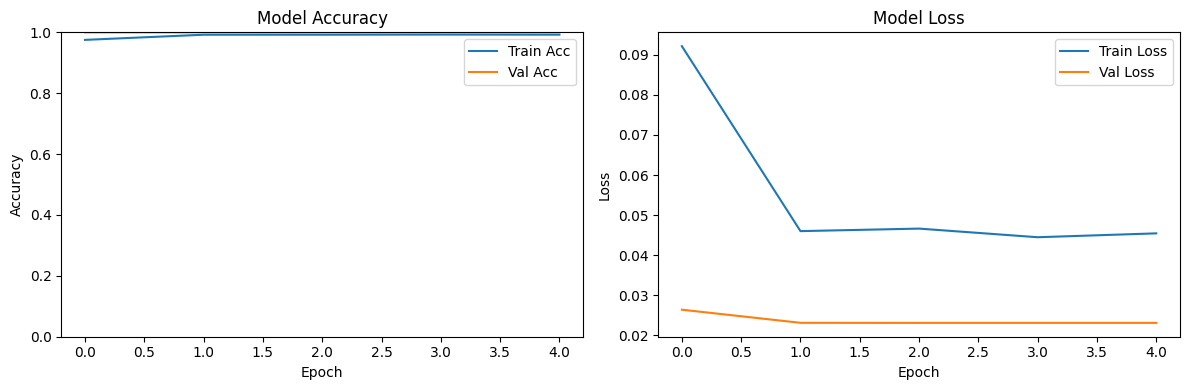

In [6]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Testing & Evaluating

In [7]:
# Load and preprocess test data
X_test, y_test = load_test(batch_size=BATCH_SIZE,downsample_step=DOWNSAMPLING_STEP,logs=1)

# One-hot encode labels
y_test = to_categorical(y_test, num_classes=4)

Loading from test1
X.shape from Data\Cross\test1: (23744, 3, 248)
Loading from test2
X.shape from Data\Cross\test2: (23744, 3, 248)
Loading from test3
X.shape from Data\Cross\test3: (23744, 3, 248)


In [8]:
[(0.715900182723999, [14, 100000, 0.00015, 0.98]), (0.7168548107147217, [12, 100000, 5e-05, 0.96]), (0.7189745903015137, [13, 100000, 5e-05, 0.92]), (0.7205188870429993, [14, 100000, 0.00015, 0.94]), (0.7219367623329163, [13, 100000, 5e-05, 0.98]), (0.7224982976913452, [14, 100000, 5e-05, 0.98]), (0.7247023582458496, [14, 100000, 0.0001, 0.94]), (0.7249410152435303, [13, 100000, 0.0001, 0.98]), (0.7268081903457642, [13, 100000, 5e-05, 0.94]), (0.7303038239479065, [14, 100000, 5e-05, 0.92]), (0.7378144860267639, [12, 100000, 0.00015, 0.98])]


[(0.715900182723999, [14, 100000, 0.00015, 0.98]),
 (0.7168548107147217, [12, 100000, 5e-05, 0.96]),
 (0.7189745903015137, [13, 100000, 5e-05, 0.92]),
 (0.7205188870429993, [14, 100000, 0.00015, 0.94]),
 (0.7219367623329163, [13, 100000, 5e-05, 0.98]),
 (0.7224982976913452, [14, 100000, 5e-05, 0.98]),
 (0.7247023582458496, [14, 100000, 0.0001, 0.94]),
 (0.7249410152435303, [13, 100000, 0.0001, 0.98]),
 (0.7268081903457642, [13, 100000, 5e-05, 0.94]),
 (0.7303038239479065, [14, 100000, 5e-05, 0.92]),
 (0.7378144860267639, [12, 100000, 0.00015, 0.98])]

In [9]:
# Evaluate
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

2226/2226 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8488 - loss: 6.4854
Test accuracy: 0.7358490824699402


In [10]:
# This piece of code collects all the instances that were predicted as 'motor' by the model in this notebook.
# Purpose: Since this model could improve on distinguishing motor and math, we could feed all predictions of 'motor' to a new model, for a second opinion
# So this code determines on what instances to ask a second opinion
X_second_op = []

counter = 0
while counter < len(y_test):
    if (list(y_test[counter])) == [0.0, 1.0, 0.0, 0.0]:
        # feed to other model
        instance = (X_test[counter])
        
        X_second_op.append(instance)

    counter = counter + 1

X_second_op = np.asarray(X_second_op)


In [11]:
# Call other model

# In y_test now replace the predictions of the initial model by the predictions of the second opinion model


2226/2226 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


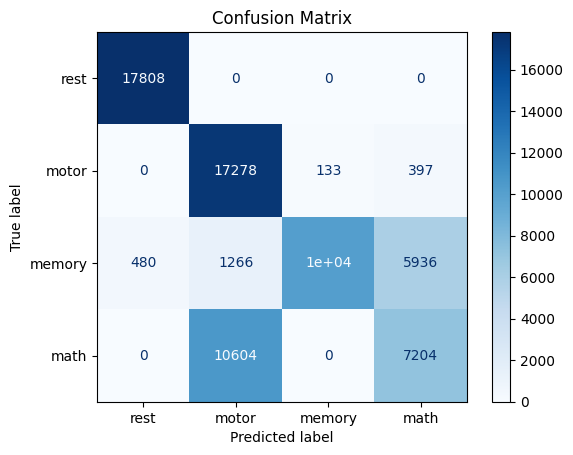

In [12]:
# Predict class probabilities
y_pred_probs = lstm_model.predict(X_test)
# Convert one-hot back to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rest", "motor", "memory", "math"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
